In [1]:
import tensorflow as tf
import ujson as json
import numpy as np

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)


In [2]:
import os
os.chdir('./src')

In [3]:
!python train.py -m ca-q-attn-qgen

w/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-03-30 01:22:27.440326: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-03-30 01:22:27.440342: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2020-03-30 01:22:27.440355: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2020-03-30 01:22:27.440367: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2020-03-30 01:22:27.440380: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2020-03-30 01:22:27.440390: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2020-03-30 01:22:27.440430: 

In [4]:
from text_gan.models import CA_Q_AttnQGen
from text_gan.data.qgen_ca_q import CA_QPair, CA_Qcfg

In [8]:
data = CA_QPair.load()
train = data.train.batch(1).skip(8).take(8)
to_gpu = tf.data.experimental.copy_to_device("/gpu:0")
train = train.apply(to_gpu)
with tf.device("/gpu:0"):
    train = train.prefetch(2)

with open(CA_Qcfg.CWORD2IDX, 'r') as f:
    cword2idx = json.load(f)
with open(CA_Qcfg.QWORD2IDX, 'r') as f:
    qword2idx = json.load(f)
cidx2emb = np.load(CA_Qcfg.CIDX2EMB)
qidx2emb = np.load(CA_Qcfg.QIDX2EMB)
model = CA_Q_AttnQGen(cidx2emb, qidx2emb)
model.model.compile(
    tf.keras.optimizers.Adam(1e-3),
    tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
)
model.load("/tf/data/attngen/model/model.tf")
model.model.summary()

Model: "Attn-Gen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Context-Tokens (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
Answer-Markers (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
Question-Tokens (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
ca_q__encoder_1 (CA_Q_Encoder)  ((None, 32), (None,  13474408    Context-Tokens[0][0]             
                                                                 Answer-Markers[0][0]      

In [9]:
cidx2word = np.full(len(cword2idx), CA_Qcfg.UNK_TOKEN, dtype='object')
for token, idx in cword2idx.items():
    cidx2word[idx] = token

qidx2word = np.full(len(qword2idx), CA_Qcfg.UNK_TOKEN, dtype='object')
for token, idx in qword2idx.items():
    qidx2word[idx] = token

In [10]:
pred = model.predict(train)
i = 0
for X, y in train:
    context = cidx2word[X[0]]
    answer = tf.reshape(X[0]*X[1], (-1,))
    ogques = qidx2word[y]
    ans = ''
    for ai in answer:
        if ai == 0:
            continue
        ans += cidx2word[ai] + ' '
    context = filter(lambda w: w != CA_Qcfg.PAD_TOKEN.decode('utf-8'), context)
    ques = map(lambda idx: qidx2word[idx], pred[i])
    print(f"Context:- {' '.join(context)}")
    print(f"Answer:- {ans}")
    print(f"OG Question:- {' '.join(ogques)}")
    print(f"Question:- {' '.join(ques)}")
    print("")
    i += 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
Context:- Similarly , movies and television often revert to standard , UNKNOWN UNKNOWN of classical music to convey refinement or opulence : some of the most - often heard pieces in this category include Bach ´ s Cello Suite No UNKNOWN Mozart ' s UNKNOWN UNKNOWN UNKNOWN , Vivaldi ' s 

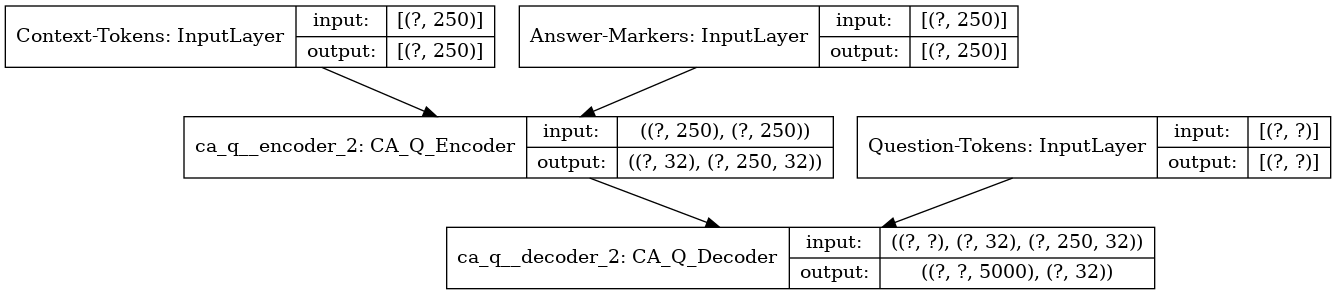

In [12]:
model.plot_model("/tf/data/processed/model.png")